# Análise Descritiva

## Load dados e infos gerais

In [1]:
import pandas as pd
import pyarrow as pa

pd.__version__, pa.__version__

('3.0.0', '23.0.0')

In [2]:
PATH = "data/sample_data.parquet"
df = pd.read_parquet(PATH, engine="fastparquet")
df.shape, df.head()


((100000, 14),
   document_number  yearmonth registry_date clearance_place_dispatch  \
 0     DI001000000 2023-10-01    2023-10-23   AEROPORTO DE VIRACOPOS   
 1     DI001000001 2023-12-01    2023-12-15          PORTO DE ITAJAÍ   
 2     DI001000002 2024-10-01    2024-10-08   AEROPORTO DE VIRACOPOS   
 3     DI001000003 2023-09-01    2023-09-19          PORTO DE SANTOS   
 4     DI001000004 2024-10-01    2024-10-16          PORTO DE ITAJAÍ   
 
     clearance_place_entry  consignee_code consignee_company_size  \
 0      PORTO DE PARANAGUÁ  96582710910444                 DEMAIS   
 1   AEROPORTO DE BRASÍLIA  11076095431713                 DEMAIS   
 2  AEROPORTO DE VIRACOPOS  89649666811829                 DEMAIS   
 3         PORTO DE SANTOS  71804559128933                 DEMAIS   
 4          PORTO DE SUAPE  25639427881692                 DEMAIS   
 
                  consignee_name  \
 0      DISTRIBUIDORA SILVA LTDA   
 1   DISTRIBUIDORA CARVALHO LTDA   
 2  IMPORTADORA FERREIRA LT

In [3]:
# Schema e Nulos
schema = (df.dtypes
          .astype(str)
          .to_frame("dtype")
          .join(df.isna().mean().rename("na_rate"))
          .sort_values("na_rate", ascending=False))

schema.head(30)


,dtype,na_rate
registry_date,datetime64[ns],0.01300
country_origin_code,float64,0.00750
ncm_code,object,0.00059
transport_mode_pt,object,0.00040
clearance_place_entry,object,0.00040
shipper_name,object,0.00010
consignee_code,object,0.00000
clearance_place_dispatch,object,0.00000
document_number,object,0.00000
yearmonth,datetime64[ns],0.00000


In [4]:
# Verificar valores repetidos (ID)
df.duplicated().sum()
cand_keys = ["document_number"]
for c in cand_keys:
    if c in df.columns:
        print(c, df[c].nunique(), " / ", len(df))


document_number 100000  /  100000


## Distribuição Canal [TARGET]


In [5]:
df['channel'].value_counts(dropna=False)


channel
VERDE       97016
VERMELHO     2071
AMARELO       866
CINZA          47
Name: count, dtype: int64

In [6]:
# Frequências
vc = df["channel"].value_counts()
vc_pct = df["channel"].value_counts(normalize=True)

pd.concat([vc, vc_pct], axis=1, keys=["count", "share"])


,count,share
channel,,
VERDE,97016,0.97016
VERMELHO,2071,0.02071
AMARELO,866,0.00866
CINZA,47,0.00047


## Estatísticas Descritivas

In [7]:
# Variáveis Categóricas

cat_cols = df.select_dtypes(include=["object", "string"]).columns.drop("channel")

summary_cat = []
for c in cat_cols:
    summary_cat.append({
        "col": c,
        "nunique": df[c].nunique(),
        "top_1_share": df[c].value_counts(normalize=True).iloc[0]
    })

pd.DataFrame(summary_cat).sort_values("nunique", ascending=False)


,col,nunique,top_1_share
0,document_number,100000,0.000010
3,consignee_code,3907,0.069660
9,shipper_name,1920,0.000810
5,consignee_name,1655,0.069670
8,ncm_code,28,0.037372
1,clearance_place_dispatch,12,0.084220
2,clearance_place_entry,12,0.084834
6,clearance_place,10,0.101640
7,transport_mode_pt,7,0.529672
4,consignee_company_size,3,0.957040


In [8]:
# Variáveis Numéricas
df["country_origin_code"].nunique()


32

# Análise Univariada

## Distribuição de features

In [9]:
def channel_risk_table(df, feature, target="channel", min_n=100):
    t = (
        df.groupby([feature, target])
          .size()
          .unstack(fill_value=0)
    )
    t["n"] = t.sum(axis=1)
    t = t[t["n"] >= min_n]
    return t.sort_values("n", ascending=False)


In [10]:
features_risk = [
    "ncm_code",
    "transport_mode_pt",
    "clearance_place_entry",
    "clearance_place_dispatch",
    "consignee_company_size",
    "country_origin_code"
]

for f in features_risk:
    print(f"\n===== {f} =====")
    display(channel_risk_table(df, f))



===== ncm_code =====


channel,AMARELO,CINZA,VERDE,VERMELHO,n
ncm_code,,,,,
39239000,30,1,3627,77,3735
84431100,36,2,3561,64,3663
40169300,23,2,3554,72,3651
40169990,31,4,3514,86,3635
73269010,40,2,3524,67,3633
73182900,37,0,3526,65,3628
39269090,35,2,3508,66,3611
85423990,35,0,3506,65,3606
22072000,29,1,3443,129,3602



===== transport_mode_pt =====


channel,AMARELO,CINZA,VERDE,VERMELHO,n
transport_mode_pt,,,,,
MARITIMA,433,22,51542,949,52946
AEREA,403,24,42539,1073,44039
RODOVIARIA,24,1,2152,35,2212
POSTAL,5,0,571,12,588



===== clearance_place_entry =====


channel,AMARELO,CINZA,VERDE,VERMELHO,n
clearance_place_entry,,,,,
PORTO DE PARANAGUÁ,68,6,8233,173,8480
PORTO DE SUAPE,77,4,8186,167,8434
PORTO DE ITAJAÍ,53,7,8169,184,8413
PORTO DO RIO DE JANEIRO,64,4,8165,172,8405
AEROPORTO DO GALEÃO,91,6,8120,166,8383
PORTO DE VITÓRIA,64,5,8107,182,8358
AEROPORTO DE VIRACOPOS,74,2,8078,166,8320
PORTO DE SANTOS,69,4,8055,161,8289
AEROPORTO DE GUARULHOS,85,1,8021,159,8266



===== clearance_place_dispatch =====


channel,AMARELO,CINZA,VERDE,VERMELHO,n
clearance_place_dispatch,,,,,
PORTO DE PARANAGUÁ,72,6,8179,165,8422
PORTO DE SUAPE,90,5,8140,174,8409
PORTO DE SALVADOR,87,2,8113,181,8383
PORTO DO RIO DE JANEIRO,66,3,8137,165,8371
AEROPORTO DO GALEÃO,53,4,8143,166,8366
PORTO DE SANTOS,60,3,8128,170,8361
AEROPORTO DE GUARULHOS,70,4,8077,190,8341
AEROPORTO DE VIRACOPOS,70,3,8087,172,8332
AEROPORTO DE CONGONHAS,70,4,8062,178,8314



===== consignee_company_size =====


channel,AMARELO,CINZA,VERDE,VERMELHO,n
consignee_company_size,,,,,
DEMAIS,816,46,92890,1952,95704
EMPRESA DE PEQUENO PORTE,44,0,3685,106,3835
MICRO EMPRESA,6,1,441,13,461



===== country_origin_code =====


channel,AMARELO,CINZA,VERDE,VERMELHO,n
country_origin_code,,,,,
160.0,26,1,3101,59,3187
386.0,30,0,3092,60,3182
246.0,31,1,3084,52,3168
105.0,20,1,3087,60,3168
643.0,38,0,3065,56,3159
380.0,30,2,3058,63,3153
368.0,38,4,2989,112,3143
158.0,20,2,3068,51,3141
116.0,28,0,3055,54,3137


### Análise NCM

In [11]:
df["ncm_chapter"] = df["ncm_code"].str.slice(0, 2)
df["ncm_4d"] = df["ncm_code"].str.slice(0, 4)

channel_risk_table(df, "ncm_chapter", min_n=200)
channel_risk_table(df, "ncm_4d", min_n=200)


channel,AMARELO,CINZA,VERDE,VERMELHO,n
ncm_4d,,,,,
4016,54,6,7068,158,7286
7326,67,3,7041,121,7232
7318,58,4,6996,131,7189
2207,52,4,6855,244,7155
2936,69,5,6886,138,7098
8708,74,3,6869,149,7095
8517,66,4,6883,130,7083
8544,62,1,6842,157,7062
3822,43,7,6788,207,7045


In [12]:
df["ncm_chapter"] = df["ncm_code"].str.slice(0, 2)
df["ncm_4d"] = df["ncm_code"].str.slice(0, 4)

channel_risk_table(df, "ncm_chapter", min_n=200)
channel_risk_table(df, "ncm_4d", min_n=200)


channel,AMARELO,CINZA,VERDE,VERMELHO,n
ncm_4d,,,,,
4016,54,6,7068,158,7286
7326,67,3,7041,121,7232
7318,58,4,6996,131,7189
2207,52,4,6855,244,7155
2936,69,5,6886,138,7098
8708,74,3,6869,149,7095
8517,66,4,6883,130,7083
8544,62,1,6842,157,7062
3822,43,7,6788,207,7045


## Outliers

In [13]:
# Datas inválidas
df["registry_date"].isna().mean()


np.float64(0.013)

In [14]:
# transporte
df["transport_mode_pt"].value_counts()

transport_mode_pt
MARITIMA                  52946
AEREA                     44039
RODOVIARIA                 2212
POSTAL                      588
FERROVIARIA                  89
MEIOS PRÓPRIOS               46
ENTRADA/SAÍDA FICTÍCIA       40
Name: count, dtype: int64

In [15]:
# tamanho empresa
df["consignee_company_size"].value_counts()

consignee_company_size
DEMAIS                      95704
EMPRESA DE PEQUENO PORTE     3835
MICRO EMPRESA                 461
Name: count, dtype: int64

## Verificar range colunas de datas

In [16]:
dates = ['registry_date', 'yearmonth']

for c in dates[:10]:
    try:
        s = pd.to_datetime(df[c], errors="coerce")
        print(c, s.min(), "->", s.max(), "na_rate:", s.isna().mean())
    except Exception as e:
        print(c, "erro:", e)


registry_date 2023-01-01 00:00:00 -> 2025-01-31 00:00:00 na_rate: 0.013
yearmonth 2023-01-01 00:00:00 -> 2025-01-01 00:00:00 na_rate: 0.0


## Verificar sazonalidade por canal

In [17]:
DATE_COL = "registry_date"
TARGET = "channel"

tmp = df.dropna(subset=[DATE_COL]).copy()
pivot = pd.crosstab(tmp[DATE_COL], tmp[TARGET]).sort_index()
pivot.head()

channel,AMARELO,CINZA,VERDE,VERMELHO
registry_date,,,,
2023-01-01,0,0,4,0
2023-01-02,1,0,97,4
2023-01-03,1,0,106,2
2023-01-04,1,0,105,1
2023-01-05,1,0,122,1


### Plots - Data por canal

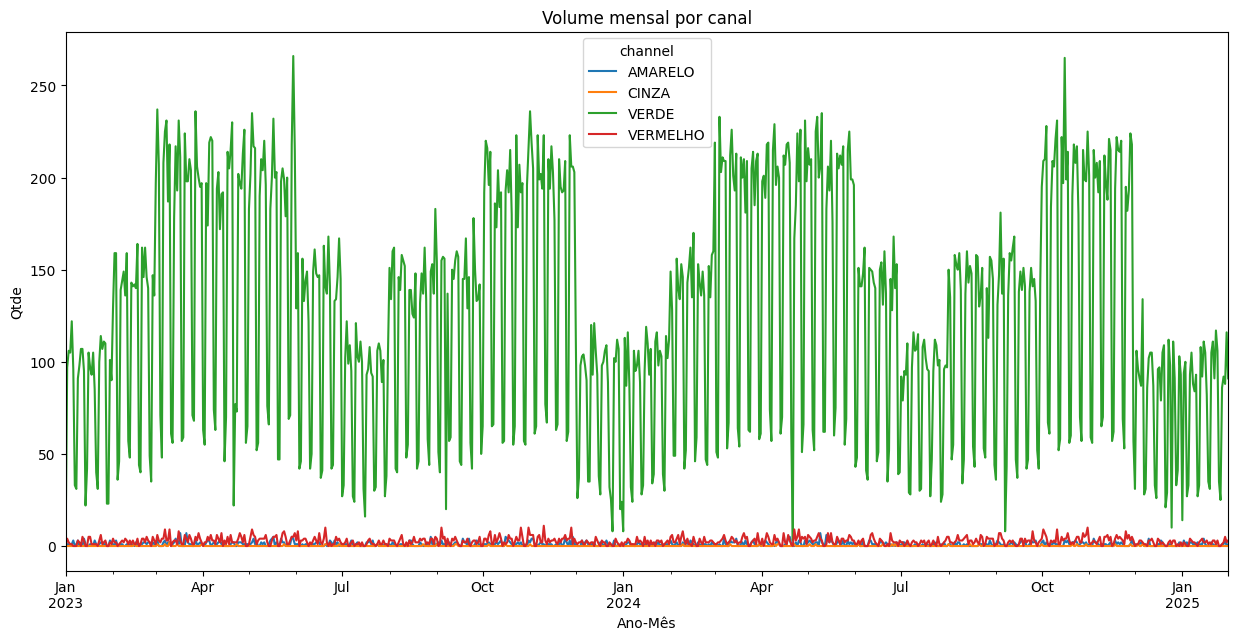

In [18]:
import matplotlib.pyplot as plt

pivot.plot(figsize=(15,7))
plt.title("Volume mensal por canal")
plt.xlabel("Ano-Mês")
plt.ylabel("Qtde")
plt.xticks(rotation=0)
plt.show()


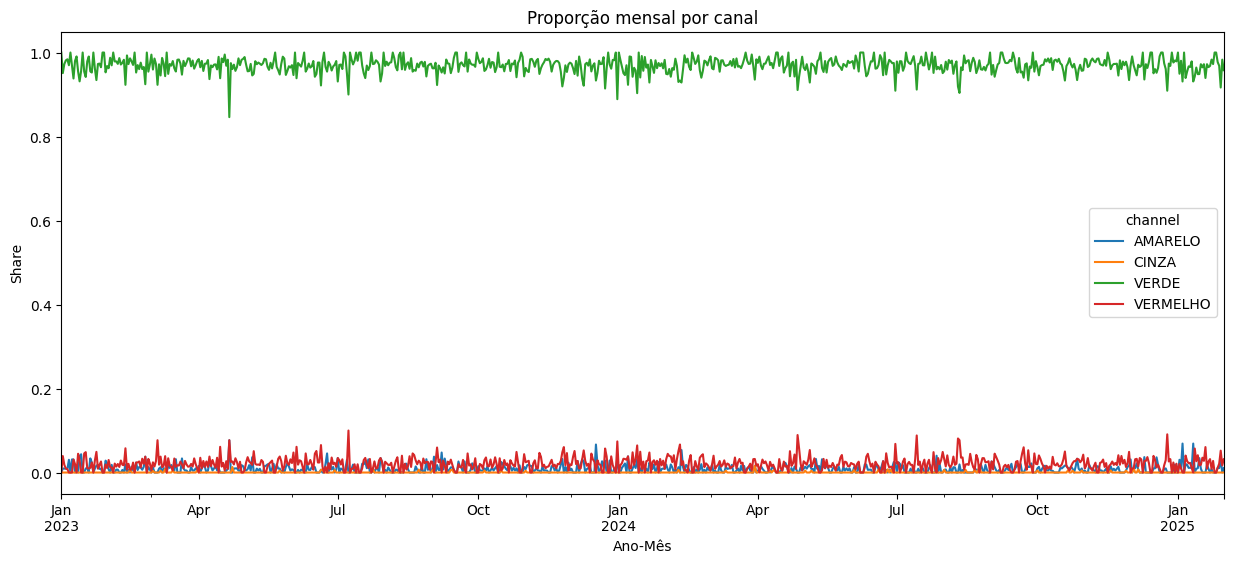

In [19]:
share = pivot.div(pivot.sum(axis=1), axis=0)
share.plot(figsize=(15,6))
plt.title("Proporção mensal por canal")
plt.xlabel("Ano-Mês")
plt.ylabel("Share")
plt.xticks(rotation=0)
plt.show()


# Análise temporal

In [20]:
tmp = df.copy()

tmp["registry_date"] = pd.to_datetime(tmp["registry_date"], errors="coerce")
tmp["ym"] = tmp["registry_date"].dt.to_period("M")

tmp["ncm_code"] = tmp["ncm_code"].astype("string")
tmp["ncm_chapter"] = tmp["ncm_code"].str.slice(0, 2)
tmp["ncm_4d"] = tmp["ncm_code"].str.slice(0, 4)


In [21]:
tmp = df.dropna(subset=["registry_date"]).copy()
tmp["registry_date"] = pd.to_datetime(tmp["registry_date"], errors="coerce")
tmp["ym"] = tmp["registry_date"].dt.to_period("M").astype(str)

tmp["ncm_code"] = tmp["ncm_code"].astype("string")
tmp["ncm_chapter"] = tmp["ncm_code"].str.slice(0, 2)

# contagens
counts = (
    tmp.groupby(["ym", "ncm_chapter", "channel"])
       .size()
       .reset_index(name="n")
)

# share dentro de (ym, ncm_chapter)
counts["share"] = counts["n"] / counts.groupby(["ym", "ncm_chapter"])["n"].transform("sum")

counts.head()


,ym,ncm_chapter,channel,n,share
0,2023-01,22,AMARELO,2,0.009756
1,2023-01,22,VERDE,198,0.965854
2,2023-01,22,VERMELHO,5,0.024390
3,2023-01,29,VERDE,200,0.995025
4,2023-01,29,VERMELHO,1,0.004975


In [22]:
# Risk table por modal
t = (
    df.groupby(["transport_mode_pt", "channel"])
      .size()
      .unstack(fill_value=0)
)
t["n"] = t.sum(axis=1)

share = t.drop(columns="n").div(t["n"], axis=0)
out = t.join(share.add_prefix("share_")).sort_values("n", ascending=False)

out


channel,AMARELO,CINZA,VERDE,VERMELHO,n,share_AMARELO,share_CINZA,share_VERDE,share_VERMELHO
transport_mode_pt,,,,,,,,,
MARITIMA,433,22,51542,949,52946,0.008178,0.000416,0.973482,0.017924
AEREA,403,24,42539,1073,44039,0.009151,0.000545,0.965939,0.024365
RODOVIARIA,24,1,2152,35,2212,0.010850,0.000452,0.972875,0.015823
POSTAL,5,0,571,12,588,0.008503,0.000000,0.971088,0.020408
FERROVIARIA,0,0,88,1,89,0.000000,0.000000,0.988764,0.011236
MEIOS PRÓPRIOS,0,0,45,1,46,0.000000,0.000000,0.978261,0.021739
ENTRADA/SAÍDA FICTÍCIA,1,0,39,0,40,0.025000,0.000000,0.975000,0.000000


### Plot Canal por Modal

<Axes: title={'center': 'Distribuição do canal por modal'}, xlabel='transport_mode_pt'>

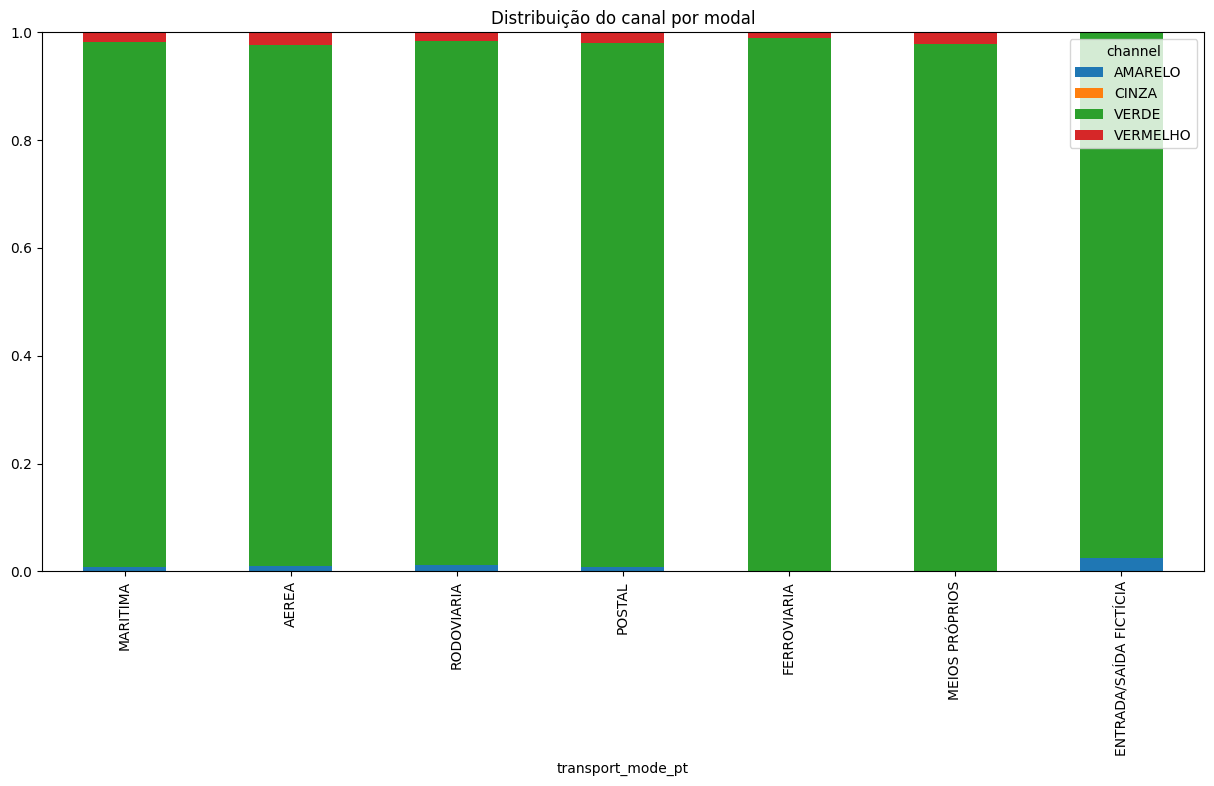

In [23]:
share.loc[out.index].plot(kind="bar", stacked=True, figsize=(15,7),
                          title="Distribuição do canal por modal")


### Volume por tempo

<Axes: title={'center': 'Volume total de processos por mês'}, xlabel='ym'>

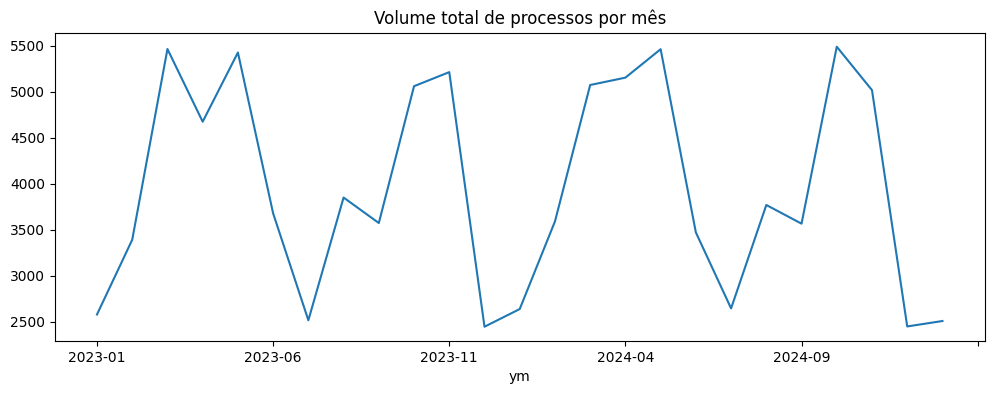

In [24]:
vol = tmp.groupby("ym").size()

vol.plot(figsize=(12,4), title="Volume total de processos por mês")


### Tendência por canal

In [25]:
DATE_COL = "registry_date"
TARGET = "channel"

tmp = df.dropna(subset=[DATE_COL]).copy()
tmp[DATE_COL] = pd.to_datetime(tmp[DATE_COL], errors="coerce")

# crie features temporais uma vez
tmp["year"]  = tmp[DATE_COL].dt.year
tmp["month"] = tmp[DATE_COL].dt.month
tmp["ym"]    = tmp[DATE_COL].dt.to_period("M").astype(str)
tmp["dow"]   = tmp[DATE_COL].dt.dayofweek


<Axes: title={'center': 'Volume mensal por canal'}, xlabel='ym'>

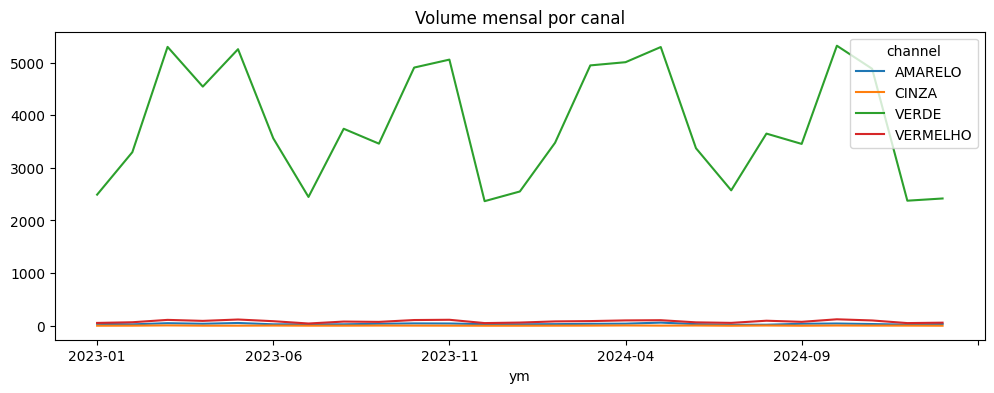

In [26]:
vol_channel = (
    tmp.groupby(["ym", TARGET])
       .size()
       .unstack(fill_value=0)
       .sort_index()
)

vol_channel.plot(figsize=(12,4), title="Volume mensal por canal")


<Axes: title={'center': 'Proporção mensal por canal'}, xlabel='ym'>

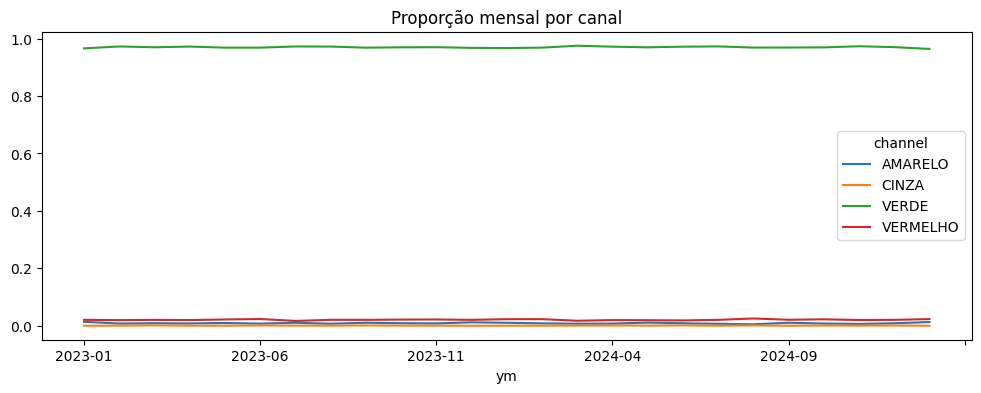

In [27]:
# Proporção por canal
share_channel = vol_channel.div(vol_channel.sum(axis=1), axis=0)

share_channel.plot(figsize=(12,4), title="Proporção mensal por canal")


### Sazonalidade

In [30]:
DATE_COL = "registry_date"
TARGET = "channel"

tmp = df.dropna(subset=[DATE_COL]).copy()
tmp[DATE_COL] = pd.to_datetime(tmp[DATE_COL], errors="coerce")

# features temporais
tmp["year"] = tmp[DATE_COL].dt.year
tmp["month"] = tmp[DATE_COL].dt.month
tmp["ym"] = tmp[DATE_COL].dt.to_period("M").astype(str)
tmp["dow"] = tmp[DATE_COL].dt.dayofweek


In [31]:
# tabela month x channel com contagens
ct = pd.crosstab(tmp["month"], tmp[TARGET])

# share dentro do mês
season_share = ct.div(ct.sum(axis=1), axis=0)

season_share.head()

channel,AMARELO,CINZA,VERDE,VERMELHO
month,,,,
1,0.012168,0.000000,0.965696,0.022136
2,0.008022,0.000286,0.970491,0.021200
3,0.007972,0.000759,0.972383,0.018886
4,0.007734,0.000611,0.972016,0.019640
5,0.010195,0.000276,0.969048,0.020481


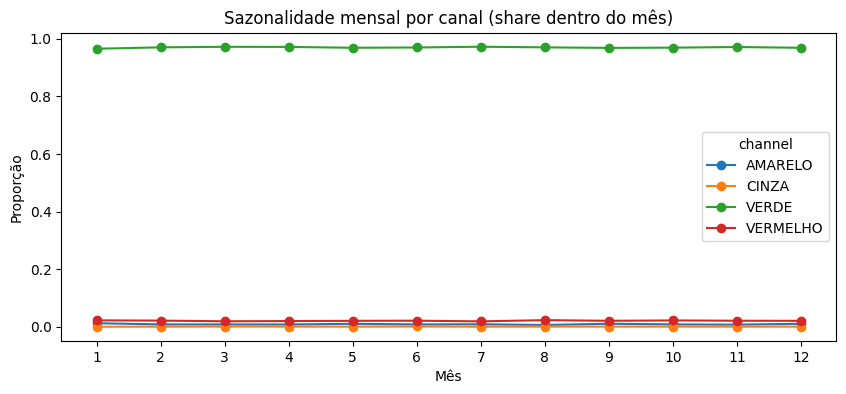

In [32]:
season_share.plot(marker="o", figsize=(10,4))
plt.title("Sazonalidade mensal por canal (share dentro do mês)")
plt.xlabel("Mês")
plt.ylabel("Proporção")
plt.xticks(range(1,13))
plt.show()
 

## Demais visualizações

### Tipo de correlação
As métricas de correlação de Pearson e Spearman não são adequadas neste contexto devido à natureza das variáveis do dataset:

A maioria das features é categórica nominal, sem ordenação natural
(ex.: transport_mode_pt, clearance_place, ncm_code, country_origin_code)

Pearson assume relação linear entre variáveis contínuas

Spearman assume ordenação semântica (rank) entre valores

No caso de variáveis categóricas nominais não existe distância numérica significativa entre categorias.

Qualquer codificação numérica (ex.: label encoding) introduziria ordem artificial

</br>

Alternativa adotada: Cramér’s V

Para avaliar associação entre variáveis categóricas, utilizamos Cramér’s V, uma medida baseada no teste qui-quadrado de independência, que:

* não assume relação linear

* não depende de ordenação artificial

* produz valores normalizados entre 0 (independência) e 1 (associação forte)

In [42]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    chi2 = chi2_contingency(ct)[0]
    n = ct.to_numpy().sum()
    r, k = ct.shape
    return np.sqrt((chi2 / n) / (min(r - 1, k - 1)))


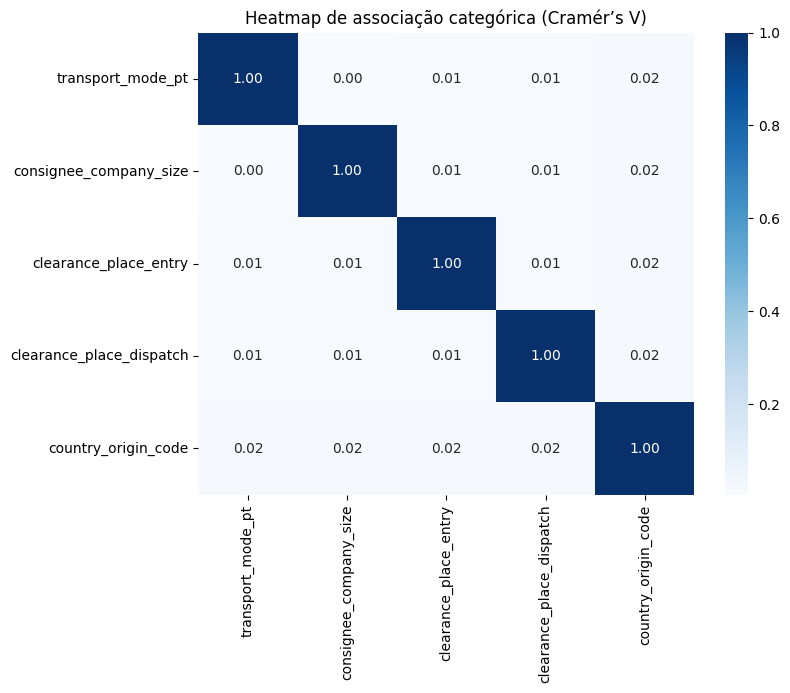

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

features_for_heatmap = [
    "transport_mode_pt",
    "consignee_company_size",
    "clearance_place_entry",
    "clearance_place_dispatch",
    "country_origin_code"
]

tmp = df.copy()
tmp["country_origin_code"] = tmp["country_origin_code"].astype("Int64").astype("string")

assoc = pd.DataFrame(index=features_for_heatmap, columns=features_for_heatmap, dtype=float)

for a in features_for_heatmap:
    for b in features_for_heatmap:
        assoc.loc[a, b] = cramers_v(tmp[a], tmp[b])

plt.figure(figsize=(8,6))
sns.heatmap(assoc, annot=True, fmt=".2f", cmap="Blues")
plt.title("Heatmap de associação categórica (Cramér’s V)")
plt.show()



Features não são redundantes entre si

Temos baixo risco de multicolinearidade categórica

In [52]:
# Features de risco
risk_features = [
    "transport_mode_pt",
    "consignee_company_size",
    "clearance_place_entry",
    "clearance_place_dispatch",
    "country_origin_code",
    "consignee_name",
    "ncm_code"
]

tmp = df.copy()
tmp["country_origin_code"] = tmp["country_origin_code"].astype("Int64").astype("string")
tmp["ncm_chapter"] = tmp["ncm_code"].astype("string").str.slice(0,2)

risk_features_use = ["transport_mode_pt",
    "consignee_company_size",
    "clearance_place_entry",
    "clearance_place_dispatch",
    "country_origin_code",
    "consignee_name",
    "ncm_chapter"]


scores = []
for c in risk_features_use:
    scores.append((c, cramers_v(tmp[c], tmp["channel"])))

scores = pd.DataFrame(scores, columns=["feature", "cramers_v"]).sort_values("cramers_v", ascending=False)
scores


,feature,cramers_v
5,consignee_name,0.146490
4,country_origin_code,0.023268
6,ncm_chapter,0.019388
0,transport_mode_pt,0.014257
2,clearance_place_entry,0.011748
1,consignee_company_size,0.010103
3,clearance_place_dispatch,0.009044


<Axes: title={'center': 'Associação com o canal (Cramér’s V)'}, xlabel='feature'>

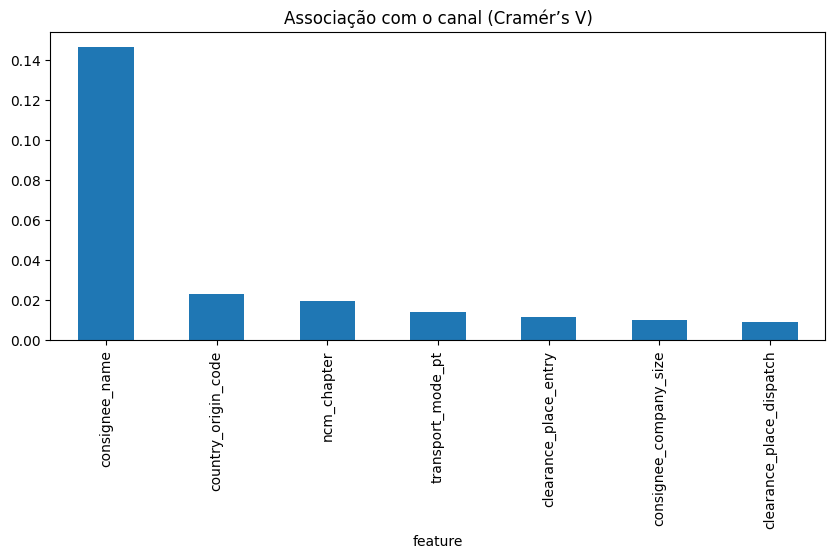

In [53]:
scores.set_index("feature").plot(kind="bar", figsize=(10,4), legend=False, title="Associação com o canal (Cramér’s V)")

A variável ```[consignee_name]``` apresenta a maior associação com o canal (Cramér’s V = 0.146).
No entanto, por se tratar de uma variável de alta cardinalidade, esse poder preditivo deve ser tratado com cautela, pois pode capturar efeitos específicos do histórico e apresentar risco de overfitting.
Em etapas posteriores, essa feature será utilizada apenas com técnicas apropriadas (ex.: target encoding com validação temporal), evitando vazamento de informação.